In [401]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import requests
import os
import alpaca_trade_api as tradeapi
import requests
import quandl
import yfinance as yf
import math
import pyfolio as pf
import quantstats as qs
import hvplot.pandas
from datetime import datetime
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns


qs.extend_pandas()
%matplotlib inline

In [4]:
load_dotenv()

True

# First API used will be Alpaca, purely to get the list of tickers

Getting key from the 'os' package through the env files:

In [5]:
alpaca_api_key = os.getenv('ALPACA_API_KEY')
alpaca_secret_key = os.getenv('ALPACA_SECRET_KEY')

#verify
type(alpaca_api_key)
type(alpaca_secret_key)

str

In [6]:
#Create the Alpaca API object
alpaca = tradeapi.REST?

#define it with the parameters
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2",
    base_url='https://paper-api.alpaca.markets'
)

Init signature:
tradeapi.REST(
    key_id: str = None,
    secret_key: str = None,
    base_url: alpaca_trade_api.common.URL = None,
    api_version: str = None,
    oauth=None,
    raw_data: bool = False,
)
Docstring:      <no docstring>
Init docstring:
:param raw_data: should we return api response raw or wrap it with
                 Entity objects.
File:           /opt/anaconda3/envs/dev/lib/python3.7/site-packages/alpaca_trade_api/rest.py
Type:           type
Subclasses:     


In [7]:
#Format Current date as ISO format
begin = pd.Timestamp('2020-06-01', tz = 'America/New_York').isoformat()
ending = pd.Timestamp('2023-01-01', tz = 'America/New_York').isoformat()

## The list_assets() method in the alpaca API allows you to list every single asset on the databse

In [8]:
active_assets = alpaca.list_assets(status='active')  # you could leave out the status to also get the inactive ones

### We are choosing the NYSE as the universe of stocks, elimate all that aren't on the NYSE:

In [9]:
# sp = [x for x in active_assets if x.exchange == 'NYSE']

z = []

for x in active_assets:
    if x.exchange =='NYSE':
        z.append(x)

Append all the tickers into a list, tickers:

In [10]:
tickers = []

for i in z:
    tickers.append(i.symbol)


The length of our first investment universe:

In [11]:
len(tickers)

2819

# 2nd Packaged that will be used: yfinance.<br>

### The reason is that yfinance provides data that stretches much further back whilst Alpaca only goes to 2016. 

Split the ticker list into 2 due to computational difficulty:

In [12]:
def split_list(a_list):
    half = len(a_list)//2
    return a_list[:half], a_list[half:]

ticker_1, ticker_2 = split_list(tickers)

Run the first lot:

In [13]:
data = yf.download(ticker_1, interval='1mo', start='2002-01-01', rounding=True)

[*********************100%***********************]  1409 of 1409 completed

114 Failed downloads:
- CXAC.U: No timezone found, symbol may be delisted
- VCXB.U: No timezone found, symbol may be delisted
- FLME.U: No timezone found, symbol may be delisted
- CODI.PRB: No timezone found, symbol may be delisted
- BMAC.U: No timezone found, symbol may be delisted
- HR: Exception('Lost data during merge despite all attempts to align data (see above)')
- BGSX.U: No timezone found, symbol may be delisted
- SCUA.U: No timezone found, symbol may be delisted
- CCV.U: No timezone found, symbol may be delisted
- CELG.RT: No timezone found, symbol may be delisted
- RJF.PRB: No timezone found, symbol may be delisted
- BLUA.U: No timezone found, symbol may be delisted
- ACRO.U: No timezone found, symbol may be delisted
- EFC.PRB: No timezone found, symbol may be delisted
- GSQB.U: No timezone found, symbol may be delisted
- HMA.U: No timezone found, symbol may be delisted
- ROSS.U: No timezone found, s

Run the second lot:

In [14]:
data1 = yf.download(ticker_2, interval='1mo', start='2002-01-01', rounding=True)

[*********************100%***********************]  1410 of 1410 completed

101 Failed downloads:
- KCGI.U: No timezone found, symbol may be delisted
- APCA.U: No timezone found, symbol may be delisted
- MKC.V: No timezone found, symbol may be delisted
- TRAQ.U: No timezone found, symbol may be delisted
- NI.PRB: No timezone found, symbol may be delisted
- NGC.U: No timezone found, symbol may be delisted
- TGR.U: No timezone found, symbol may be delisted
- MFA.PRB: No timezone found, symbol may be delisted
- ATH.PRB: No timezone found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
- AKO.B: No timezone found, symbol may be delisted
- NETC.U: No timezone found, symbol may be delisted
- TRIS.U: No timezone found, symbol may be delisted
- ATAQ.U: No timezone found, symbol may be delisted
- IBER.U: No timezone found, symbol may be delisted
- MITT.PRB: No timezone found, symbol may be delisted
- JWSM.U: No timezone found, symbol may be delisted
- BI

## **1st Universe:**<br>Below the dataframe 'prices_df' is all of the prices for 2824 stocks on the NYSE from 2002 and 2023

In [127]:
master_df1 = data['Adj Close']
master_df2 = data1['Adj Close']

prices_df = pd.concat([master_df1, master_df2], axis=1)


prices_df.head(9)

,ACAQ,ACCO,ACDI,ACDI.U,ACEL,ACHR,ACI,ACM,ACP,ACR,...,ZGN,ZH,ZIM,ZIP,ZTO,ZTR,ZTS,ZUO,ZVIA,ZWS
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.29,NaN,NaN,NaN,NaN
2002-02-01 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.27,NaN,NaN,NaN,NaN
2002-03-01 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.24,NaN,NaN,NaN,NaN
2002-04-01 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.24,NaN,NaN,NaN,NaN
2002-05-01 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.25,NaN,NaN,NaN,NaN
2002-06-01 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.88,NaN,NaN,NaN,NaN
2002-07-01 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.80,NaN,NaN,NaN,NaN
2002-08-01 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.91,NaN,NaN,NaN,NaN
2002-09-01 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.85,NaN,NaN,NaN,NaN


### Checking number of null values

In [128]:
prices_df.isnull().mean()

ACAQ      0.944882
ACCO      0.173228
ACDI      0.944882
ACDI.U    1.000000
ACEL      0.740157
            ...   
ZTR       0.000000
ZTS       0.523622
ZUO       0.767717
ZVIA      0.921260
ZWS       0.480315
Length: 2819, dtype: float64

### We excluded all that had less than 25% of their values

In [129]:
new_price_df = [] # Define Empty List

for values in prices_df.columns: # Iterating through the values in the columns in prices_df
    if prices_df[values].isnull().mean() < 0.75: # prices_df['values']
        new_price_df.append(prices_df[values])

### Transposed & changed the index to remove the intraday time

In [130]:
new_price_df = pd.DataFrame(new_price_df)
new_price_df1 = new_price_df.T


new_price_df1

,ACCO,ACEL,ACM,ACP,ACR,ACRE,AGM,AGR,AGRO,AGX,...,YEXT,YPF,YRD,YUM,YUMC,ZBH,ZTO,ZTR,ZTS,ZWS
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,29.74,NaN,NaN,4.53,...,NaN,6.45,NaN,7.27,NaN,28.88,NaN,3.29,NaN,NaN
2002-02-01 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,27.68,NaN,NaN,3.84,...,NaN,6.31,NaN,7.70,NaN,31.75,NaN,3.27,NaN,NaN
2002-03-01 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,28.16,NaN,NaN,4.17,...,NaN,6.66,NaN,7.66,NaN,30.23,NaN,3.24,NaN,NaN
2002-04-01 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,23.86,NaN,NaN,3.66,...,NaN,5.50,NaN,8.22,NaN,30.81,NaN,3.24,NaN,NaN
2002-05-01 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,19.61,NaN,NaN,3.62,...,NaN,4.06,NaN,8.33,NaN,31.05,NaN,3.25,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01 00:00:00-04:00,4.54,9.82,75.28,6.01,10.68,11.92,114.30,40.25,8.50,34.67,...,5.32,7.64,0.807,118.25,41.35,113.35,16.89,6.44,150.78,23.49
2022-11-01 00:00:00-04:00,5.49,8.55,85.00,6.87,9.86,12.03,124.86,42.32,8.11,37.95,...,5.33,8.39,1.080,128.66,55.12,120.10,25.07,6.95,154.14,24.21
2022-12-01 00:00:00-05:00,5.59,7.70,84.93,6.60,8.26,9.94,111.83,42.98,8.29,36.88,...,6.53,9.19,1.370,128.08,54.65,127.50,26.87,6.55,146.55,21.15


## We are left with 1933 stocks that have at least 25% of their monthly stock returns

In [131]:
#prices_df.fillna(0)

# Calculating Momentum ranks to formulate portfolio each month

### Below is the 12 month momentum of these stocks

In [330]:
lookback = 11

#IF MONTHLY
momentum_return = new_price_df1.pct_change(periods=lookback)
momentum_return = momentum_return.iloc[11:,:]
momentum_return.head(5)

,ACCO,ACEL,ACM,ACP,ACR,ACRE,AGM,AGR,AGRO,AGX,...,YEXT,YPF,YRD,YUM,YUMC,ZBH,ZTO,ZTR,ZTS,ZWS
Date,,,,,,,,,,,,,,,,,,,,,
2002-12-01 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,-0.348016,NaN,NaN,-0.434879,...,NaN,-0.226357,NaN,-0.132050,NaN,0.276316,NaN,-0.182371,NaN,NaN
2003-01-01 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,-0.403179,NaN,NaN,0.427083,...,NaN,-0.104596,NaN,-0.215584,NaN,0.146457,NaN,-0.174312,NaN,NaN
2003-02-01 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,-0.459517,NaN,NaN,0.232614,...,NaN,-0.030030,NaN,-0.190601,NaN,0.303672,NaN,-0.166667,NaN,NaN
2003-03-01 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,-0.422045,NaN,NaN,0.316940,...,NaN,0.400000,NaN,-0.228710,NaN,0.401168,NaN,-0.141975,NaN,NaN
2003-04-01 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,-0.235084,NaN,NaN,0.331492,...,NaN,0.980296,NaN,-0.226891,NaN,0.341063,NaN,-0.123077,NaN,NaN


In [331]:
# How concentrated to do we want the portfolio?
number_of_stocks = 100

# We loop over each month and rank the stocks to see which tickers will be in the portfolio for each period.

portfolio_of_stocks = pd.DataFrame()

for date in momentum_return.index:
    ab = momentum_return.loc[date].nlargest(number_of_stocks).index
    portfolio_of_stocks[date] = ab # date is a list of dates (a key), that has a list associated with each date (key)

/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.


Visualise portfolio each month:

In [332]:
portfolio_each_month = portfolio_of_stocks.T
portfolio_each_month.head(5)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2002-12-01 00:00:00-05:00,MED,USNA,CYD,LCI,HL,CLH,EGY,DAR,KGC,GFI,...,PHX,SJM,BOH,GIM,HP,BG,BHP,PBT,CHS,CRL
2003-01-01 00:00:00-05:00,USNA,MED,LCI,CYD,DAR,HL,EGY,CLH,WT,KGC,...,BALL,TDF,INT,BOH,OFC,BHE,GPS,CLF,GIM,PXD
2003-02-01 00:00:00-05:00,USNA,MED,LCI,CYD,DAR,EGY,GEL,HL,WT,BBAR,...,UHT,TPL,NHI,TRP,ROK,VTN,PXD,CRT,BMI,SPH
2003-03-01 00:00:00-05:00,MED,USNA,WT,CYD,DAR,EGY,GEL,LCI,TEO,BBAR,...,ADC,TREX,VTN,KSM,MVT,CHN,IIIN,HOV,SPG,BHK
2003-04-01 00:00:00-05:00,MED,TEO,USNA,TGS,BBAR,DAR,WT,LCI,CYD,IRS,...,RNR,SMG,EW,GIL,KNX,MTR,FRT,SGU,GTY,OLP


### Returns DataFrame = clean_ret_df

In [333]:
clean_ret_df = new_price_df1.pct_change()
clean_ret_df1 = clean_ret_df.iloc[1:,:]
clean_ret_df1.head(5)

,ACCO,ACEL,ACM,ACP,ACR,ACRE,AGM,AGR,AGRO,AGX,...,YEXT,YPF,YRD,YUM,YUMC,ZBH,ZTO,ZTR,ZTS,ZWS
Date,,,,,,,,,,,,,,,,,,,,,
2002-02-01 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,-0.069267,NaN,NaN,-0.152318,...,NaN,-0.021705,NaN,0.059147,NaN,0.099377,NaN,-0.006079,NaN,NaN
2002-03-01 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,0.017341,NaN,NaN,0.085938,...,NaN,0.055468,NaN,-0.005195,NaN,-0.047874,NaN,-0.009174,NaN,NaN
2002-04-01 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,-0.152699,NaN,NaN,-0.122302,...,NaN,-0.174174,NaN,0.073107,NaN,0.019186,NaN,0.000000,NaN,NaN
2002-05-01 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,-0.178122,NaN,NaN,-0.010929,...,NaN,-0.261818,NaN,0.013382,NaN,0.007790,NaN,0.003086,NaN,NaN
2002-06-01 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,-0.138705,NaN,NaN,0.011050,...,NaN,-0.044335,NaN,-0.085234,NaN,0.019646,NaN,-0.113846,NaN,NaN


### This function allows you to see for each date, what the portfolio is holding:

In [334]:
def port_sort(dates):
    top100 = momentum_return.loc[dates].nlargest(number_of_stocks).index
    
    return top100

#### Test the first month:

In [335]:
port_sort('2002-12-01') # Select first Portfolio

Index(['MED', 'USNA', 'CYD', 'LCI', 'HL', 'CLH', 'EGY', 'DAR', 'KGC', 'GFI',
       'DRD', 'WT', 'HMY', 'CDE', 'PAR', 'ASA', 'BSX', 'CNC', 'AU', 'CPF',
       'OIS', 'BYD', 'ESTE', 'MPX', 'NUS', 'TREX', 'SRI', 'IBN', 'SJT', 'GPK',
       'CULP', 'GRMN', 'SRT', 'CAL', 'CCK', 'GIL', 'EPAC', 'AVD', 'SKT', 'AUY',
       'HOV', 'AGCO', 'GEL', 'BMI', 'PXD', 'NL', 'FMC', 'PRG', 'WCN', 'TPR',
       'THO', 'SSL', 'AUB', 'MSB', 'HAL', 'UGI', 'IIIN', 'MUX', 'CW', 'EPC',
       'NVR', 'BPT', 'ERF', 'BIO', 'EQNR', 'VMI', 'DX', 'FCN', 'NEM', 'SR',
       'GHC', 'PB', 'OFG', 'STE', 'UBP', 'DCO', 'TBI', 'TTC', 'PDS', 'BALL',
       'JEF', 'AEM', 'CRK', 'MT', 'AAIC', 'FTI', 'AME', 'RRC', 'ZBH', 'ROL',
       'PHX', 'SJM', 'BOH', 'GIM', 'HP', 'BG', 'BHP', 'PBT', 'CHS', 'CRL'],
      dtype='object')

## Calculating the values:

The reason we use [1:2] is because we construct the portfolio at the beginning of each month, whereas the returns are calculated for that months end from start of month <br><br> Buy 100 stocks on March 1st, but calculate the returns of that portfolio chosen on the 31st of March (e.g. r[31st] / r[1st] - 1 ) <br> <br> The [1:2] pushes the return values one month ahead to calculate the forward month return

In [336]:
# Here we are MATCHING the value for each stock at '2020-02-01' by using clean_ret_df1.loc['2020-02-01'], with the tickers we want for each month with port_sort('2020-03-01').

portfolio = clean_ret_df1.loc['2020-02-01':, port_sort('2020-02-01')][1:2]
portfolio #At this month, these are all the stocks returns we would use to find the return

,COE,MAXR,DRD,ASPN,ODV,SAFE,SPCE,HOV,TDOC,SHOP,...,AMRC,DEA,CCS,MDC,HASI,AJRD,FICO,AQN,VGR,BURL
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-01 00:00:00-05:00,0.160464,-0.298153,-0.115385,-0.227673,0.0,0.157584,-0.399187,-0.667071,0.240477,-0.100151,...,-0.244454,0.036186,-0.564818,-0.405991,-0.398815,-0.151317,-0.181741,-0.101757,-0.189306,-0.267271


#### As an example, here is the portfolio performance for 2020-03-01:

In [337]:
print(f' The portfolio return on 2020-02-01 is {round((portfolio.mean(axis=1).values[0])*100, 3)}%')

 The portfolio return on 2020-02-01 is -21.419%


##### Can check the performance at any date:

In [338]:
def performance_check(date):
    portfolio1 = clean_ret_df1.loc[date:, port_sort(date)][1:2]
    return portfolio1.mean(axis=1).values[0]

In [339]:
performance_check('2020-02-01')

-0.2141872978461567

### Set period we're assessing:

In [340]:
period = momentum_return.index[:-1]
period

DatetimeIndex(['2002-12-01 00:00:00-05:00', '2003-01-01 00:00:00-05:00',
               '2003-02-01 00:00:00-05:00', '2003-03-01 00:00:00-05:00',
               '2003-04-01 00:00:00-05:00', '2003-05-01 00:00:00-04:00',
               '2003-06-01 00:00:00-04:00', '2003-07-01 00:00:00-04:00',
               '2003-08-01 00:00:00-04:00', '2003-09-01 00:00:00-04:00',
               ...
               '2022-04-01 00:00:00-04:00', '2022-05-01 00:00:00-04:00',
               '2022-06-01 00:00:00-04:00', '2022-07-01 00:00:00-04:00',
               '2022-08-01 00:00:00-04:00', '2022-09-01 00:00:00-04:00',
               '2022-10-01 00:00:00-04:00', '2022-11-01 00:00:00-04:00',
               '2022-12-01 00:00:00-05:00', '2023-01-01 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=242, freq='MS')

In [341]:
returns = []

for date in period: #iterating through the values on the dates that are chosen.
    returns.append(performance_check(date))

    
returns1 = pd.Series(returns, index=period)
returns_real = returns1.shift(1)
returns_real.loc['2020-03-01'] # CHECK COVID

-0.2141872978461567

In [342]:
returns_real = returns_real.iloc[1:]

## Benchmark:

S&P 500

In [343]:
benchmark = yf.download(tickers = '^GSPC', start = '2002-12-01', interval='1mo')
benchmark1 = benchmark['Adj Close'].pct_change()

[*********************100%***********************]  1 of 1 completed


In [344]:
benchmark2 = benchmark1.iloc[1:-1]
benchmark2.index = returns_real.index
benchmark2

Date
2003-01-01 00:00:00-05:00   -0.027415
2003-02-01 00:00:00-05:00   -0.017004
2003-03-01 00:00:00-05:00    0.008358
2003-04-01 00:00:00-05:00    0.081044
2003-05-01 00:00:00-04:00    0.050899
                               ...   
2022-09-01 00:00:00-04:00   -0.093396
2022-10-01 00:00:00-04:00    0.079863
2022-11-01 00:00:00-04:00    0.053753
2022-12-01 00:00:00-05:00   -0.058971
2023-01-01 00:00:00-05:00    0.061753
Freq: MS, Name: Adj Close, Length: 241, dtype: float64

In [345]:
# Combine
columns = ['Momentum Portfolio','S&P 500']

comparison = pd.concat([returns_real, benchmark2], axis=1)
comparison.columns = columns
comparison.tail(5)

,Momentum Portfolio,S&P 500
Date,,
2022-09-01 00:00:00-04:00,-0.100588,-0.093396
2022-10-01 00:00:00-04:00,0.180764,0.079863
2022-11-01 00:00:00-04:00,0.007545,0.053753
2022-12-01 00:00:00-05:00,-0.055347,-0.058971
2023-01-01 00:00:00-05:00,0.043389,0.061753


In [346]:
real_comparison = pd.DataFrame(index=comparison.index)

real_comparison['Port with Transaction Cost'] = comparison['Momentum Portfolio'] - 0.005 # Assume a 0.5% transacation cost each month
real_comparison['S&P 500'] = comparison['S&P 500']

<AxesSubplot:title={'center':'Against Benchmark 2003-2023'}, xlabel='Date', ylabel='Cumulative returns'>

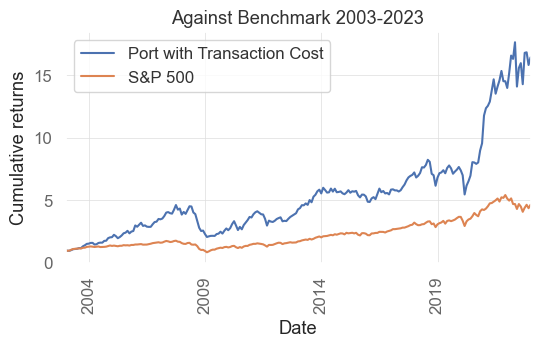

In [347]:
(1+real_comparison).cumprod().plot(figsize=[6,3], rot=90, ylabel = 'Cumulative returns', title='Against Benchmark 2003-2023')

<AxesSubplot:xlabel='Date'>

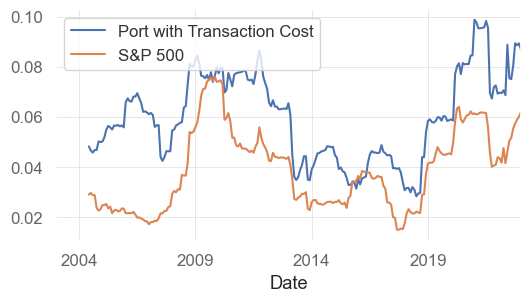

In [352]:
real_comparison.rolling(window=18).std().plot(figsize=[6,3])

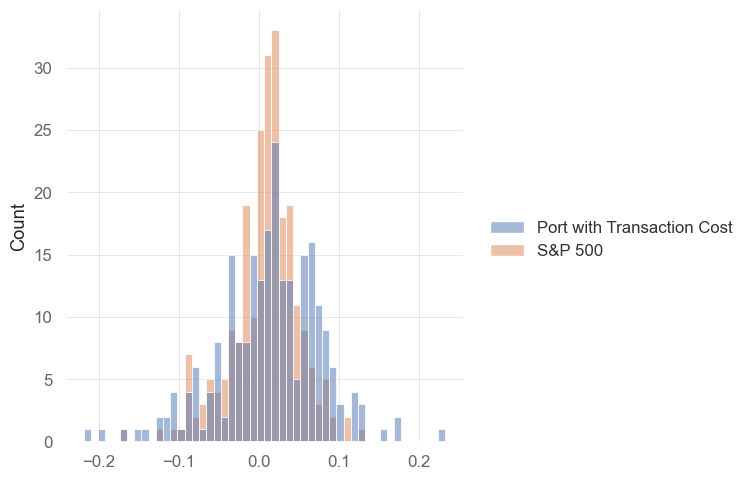

In [408]:
sns.displot(real_comparison, bins=50)

### Sharpe Ratio

In [377]:
a1 = qs.stats.sharpe(real_comparison)
b1 = qs.stats.avg_return(real_comparison)
c1 = qs.stats.max_drawdown(real_comparison)
d1 = qs.stats.cagr(real_comparison)

In [414]:
table_of_results = pd.concat([a1,b1, c1, d1], axis = 1)
table_of_results.columns = ['Sharpe','Average Monthly Return %', 'Maximum Drawdown %', 'CAGR %']

cols_to_multiply = ['Average Monthly Return %', 'Maximum Drawdown %', 'CAGR %']

table_of_results[cols_to_multiply] = table_of_results[cols_to_multiply] * 100

#Display
table_of_results3 = round(table_of_results, 2)

table_of_results3

,Sharpe,Average Monthly Return %,Maximum Drawdown %,CAGR %
Port with Transaction Cost,3.41,1.37,-55.39,15.02
S&P 500,2.72,0.73,-52.56,7.96


In [415]:
rolling_beta = qs.plots.rolling_beta(real_comparison['Port with Transaction Cost', real_comparison['S&P 500'])

SyntaxError: invalid syntax (3540782363.py, line 1)

## Regression:

In [351]:
X = real_comparison['S&P 500'].values.reshape(-1, 1)
y1 = real_comparison['Port with Transaction Cost'].values

X = sm.add_constant(X)

#fit
model = sm.OLS(y1,X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     282.7
Date:                Tue, 14 Feb 2023   Prob (F-statistic):           2.15e-42
Time:                        19:03:42   Log-Likelihood:                 415.44
No. Observations:                 241   AIC:                            -826.9
Df Residuals:                     239   BIC:                            -819.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0057      0.003      2.009      0.0

In [125]:
returns_real.index = pd.DatetimeIndex(returns_real.index)
benchmark2.index = pd.DatetimeIndex(returns_real.index)

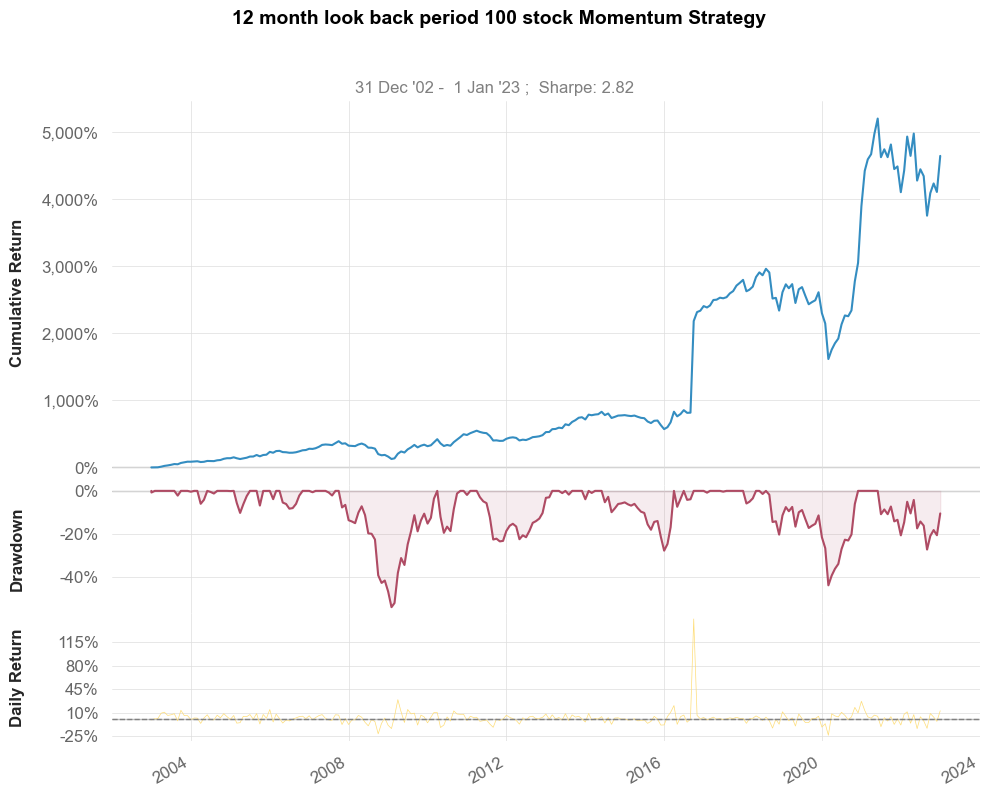

In [126]:
qs.plots.snapshot(returns_real, title='12 month look back period 100 stock Momentum Strategy')

### Vol //

In [ ]:
vol = clean_ret_df.rolling(window=12).std()*math.sqrt(12)
vol

,AAT,AB,ABB,ABBV,ABC,ABT,AC,ACN,ACP,ACV,...,XYL,YELP,YEXT,YPF,YRD,ZBH,ZTO,ZTR,ZTS,ZWS
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,0.246017,0.301541,0.308475,0.271332,0.275198,0.202100,0.304531,0.351193,0.231322,0.326104,...,0.356317,0.285132,0.392467,0.681205,0.429183,0.260443,0.386831,0.285614,0.274018,0.278536
2022-11-01,0.247261,0.298676,0.336052,0.281402,0.267595,0.230747,0.293579,0.359809,0.283428,0.326762,...,0.366521,0.329351,0.349722,0.639414,0.591468,0.210926,0.646548,0.305740,0.272795,0.285577
2022-12-01,0.235980,0.323913,0.315240,0.235255,0.241767,0.187961,0.281143,0.322355,0.284576,0.330748,...,0.366779,0.339707,0.438321,0.639007,0.675789,0.210748,0.640297,0.305396,0.235967,0.291766


In [ ]:
# #get current closing prices for tickers
# dataframe = alpaca.get_bars(
#     tickers,
#     timeframe,
#     start = begin,
#     end = ending,
# ).df.drop(columns=['open','high','low','volume','trade_count','vwap'])


In [ ]:
# dataframe.index = dataframe.index.date

In [ ]:
# new_df = dataframe.pivot(columns = 'symbol', values = 'close')

1) Collect the Data
    - A Dataframe with all stocks: prices, market capitlization (monthly or 6 monthly)

2) Clean the Data
    - Remove Na's, remove stocks that don't have data back to 2000 (Decide what the threshold is)

3) Write the code which every 6 month long's the top 10% of stocks based on momentum



5) 
Benchmark
- Get the prices
- calculated the returns


Pyfolio:
- annualized return
- annualized volatility
- concat the portfolio returns and benchmark

